# TP 7 : Dask Dataframe et Machine learning distribué

## Exercice 2 Distributed Training

On utilise les mêmes données que pour l'exercice précédent.

Le code suivant charge un fichier Parquet de training et entraine un modèle `SGDRegressor` à l'aide de `scikit-learn` sur ce jeu de données avec pour cible le prix.

In [49]:
import pandas as pd
import numpy as np
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from pathlib import Path
import time
import seaborn as sns

In [40]:
# Chargement les données
df_train = pd.read_parquet("data/houses_1000000.parquet")
df_test = pd.read_parquet("data/houses_50000.parquet")

In [41]:
# Définition des features et de la cible
X_train = df_train[["surface", "chambres", "distance_centre", "anciennete"]]
y_train = df_train["prix"]
X_test = df_test[["surface", "chambres", "distance_centre", "anciennete"]]
y_test = df_test["prix"]

In [42]:
# Entraînement avec SGDRegressor
model = SGDRegressor(max_iter=1)
n_epochs = 50
test_r2 = []

In [43]:
for epoch in range(n_epochs):
    print(f"Epoch {epoch + 1}/{n_epochs}")
    model.partial_fit(X_train, y_train)  # Passe incrémental sur toutes les données
    
    # Calcul du R2 à chaque époque
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    test_r2.append(r2_score(y_test, y_pred))

Epoch 1/50
Epoch 2/50
Epoch 3/50
Epoch 4/50
Epoch 5/50
Epoch 6/50
Epoch 7/50
Epoch 8/50
Epoch 9/50
Epoch 10/50
Epoch 11/50
Epoch 12/50
Epoch 13/50
Epoch 14/50
Epoch 15/50
Epoch 16/50
Epoch 17/50
Epoch 18/50
Epoch 19/50
Epoch 20/50
Epoch 21/50
Epoch 22/50
Epoch 23/50
Epoch 24/50
Epoch 25/50
Epoch 26/50
Epoch 27/50
Epoch 28/50
Epoch 29/50
Epoch 30/50
Epoch 31/50
Epoch 32/50
Epoch 33/50
Epoch 34/50
Epoch 35/50
Epoch 36/50
Epoch 37/50
Epoch 38/50
Epoch 39/50
Epoch 40/50
Epoch 41/50
Epoch 42/50
Epoch 43/50
Epoch 44/50
Epoch 45/50
Epoch 46/50
Epoch 47/50
Epoch 48/50
Epoch 49/50
Epoch 50/50


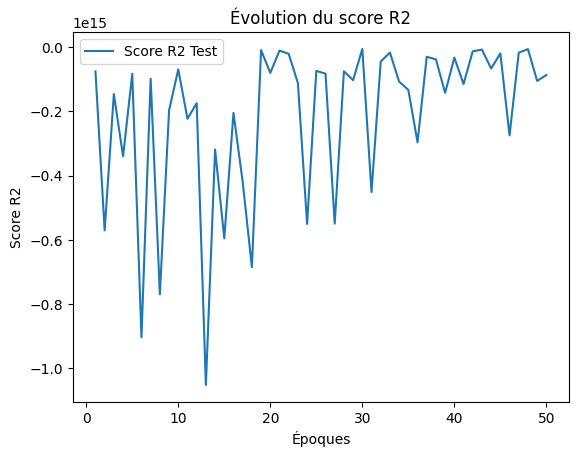

In [44]:
# Visualisation de l'évolution du `r2`
plt.plot(range(1, n_epochs + 1), test_r2, label="Score R2 Test")
plt.xlabel("Époques")
plt.ylabel("Score R2")
plt.legend()
plt.title("Évolution du score R2")
plt.show()

### Question 1
1. Observer les temps de restitution de l'entrainement pour différentes tailles de jeu de données

In [45]:
file_path='data'
p=Path(file_path)
temps=[]
fich=[10000,20000,100000,500000,1000000,10000000]
for i in range(6):
    df_train = pd.read_parquet(f"data/houses_{fich[i]}.parquet")
    df_test = pd.read_parquet("data/houses_50000.parquet")
    sub_temps=0
    for epoch in range(n_epochs):
        #print(f"Epoch {epoch + 1}/{n_epochs}")
        debut=time.time()
        model.partial_fit(X_train, y_train)  # Passe incrémental sur toutes les données
        fin=time.time()
        sub_temps+=(fin-debut)
        # Calcul du R2 à chaque époque
        y_pred = model.predict(X_test)
        r2 = r2_score(y_test, y_pred)
        test_r2.append(r2_score(y_test, y_pred)),
    temps.append(sub_temps)


In [59]:
np.exp(temps[0])

np.float64(4425.318331273474)

<Axes: >

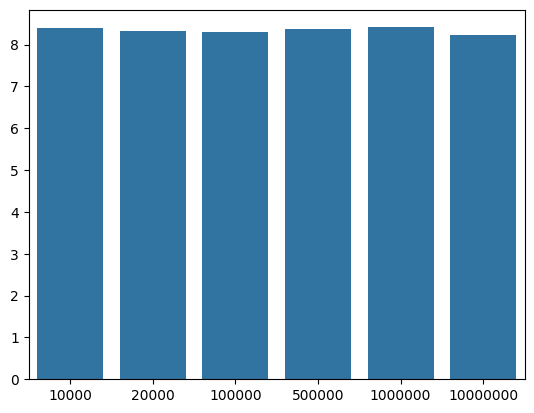

In [62]:
sns.barplot(x=fich,y=temps)


### Question 2
Utiliser Dask dataframe pour distribuer le jeu de données et adapter l'entrainement sur le jeu de donner distribuer :
    
1. *Mapper* le  `partial_fit` sur le dask dataframe 
2. Réduire les poids, pour simplifier le développement on se propose de réduire suivant la moyenne
3. Comparer les temps de restitution avec la version initiale
4. Proposer des optimisations